In [1]:
import os
import pandas as pd
import numpy as np
import io
import json
import pickle
import requests
import joblib
import math
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

/home/francisco/.local/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.22) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
def load_data(file):
    df = pd.read_csv(os.path.join("data", file))
    return df

df = load_data("train.csv")

#df_new = load_data("bank_new_observations.csv")
#target='salary'
#df_new.head()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   10000 non-null  int64  
 1   admission_id                 10000 non-null  int64  
 2   patient_id                   10000 non-null  int64  
 3   race                         10000 non-null  object 
 4   gender                       10000 non-null  object 
 5   age                          9724 non-null   object 
 6   weight                       9820 non-null   object 
 7   admission_type_code          9856 non-null   float64
 8   discharge_disposition_code   9930 non-null   float64
 9   admission_source_code        10000 non-null  int64  
 10  time_in_hospital             10000 non-null  int64  
 11  payer_code                   10000 non-null  object 
 12  medical_specialty            10000 non-null  object 
 13  has_prosthesis   

In [4]:
df.describe()

,Unnamed: 0,admission_id,patient_id,admission_type_code,discharge_disposition_code,admission_source_code,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,hemoglobin_level
count,10000.000000,10000.000000,1.000000e+04,9856.000000,9930.000000,10000.000000,10000.000000,9800.000000,10000.000000,9681.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,40697.854000,40697.854000,1.082937e+08,2.015422,3.751762,5.748500,4.340900,42.788776,1.313200,16.032848,0.37870,0.183700,0.623100,7.409000,14.179000
std,23510.882143,23510.882143,7.735092e+07,1.425137,5.318510,4.094524,2.935839,19.666400,1.683327,8.084788,1.32373,0.818304,1.250281,1.922469,1.068013
min,0.000000,0.000000,2.232000e+03,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.00000,0.000000,0.000000,1.000000,10.900000
25%,20367.250000,20367.250000,4.687067e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.00000,0.000000,0.000000,6.000000,13.400000
50%,40715.500000,40715.500000,9.073632e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.00000,0.000000,0.000000,8.000000,14.100000
75%,61071.000000,61071.000000,1.734926e+08,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.00000,0.000000,1.000000,9.000000,15.000000
max,81405.000000,81405.000000,3.766467e+08,8.000000,28.000000,22.000000,14.000000,132.000000,6.000000,70.000000,35.00000,22.000000,18.000000,16.000000,18.100000


In [5]:
def clean (df):
    
    df_clean = df.copy()
    
    df_clean['race'] = df_clean['race'].replace(['AFRICANAMERICAN', 'Afro American','African American'], 'AfricanAmerican')
    df_clean['race'] = df_clean['race'].replace(['EURO'], 'European')
    df_clean['race'] = df_clean['race'].replace(['WHITE', 'White'], 'Caucasian')
    
    df_clean['max_glu_serum'] = df_clean['max_glu_serum'].replace(['NONE'], 'None')
    df_clean['max_glu_serum'] = df_clean['max_glu_serum'].replace(['NORM'], 'Norm')
    
    df_clean['change'] = df_clean['change'].replace(['Ch'], 'Yes')
    
    df_clean['weight'] = df_clean['weight'].fillna('?')
    
    df_clean['age'] = df_clean['age'].fillna('?')

    return df_clean

In [6]:
df1 = clean(df)
df1.race.unique()

array(['Caucasian', 'European', 'AfricanAmerican', '?', 'Asian', 'Black',
       'Hispanic', 'Other', 'Latino'], dtype=object)

In [7]:
missing_values = df1.isna().sum()
print(missing_values[missing_values > 0])


admission_type_code           144
discharge_disposition_code     70
num_lab_procedures            200
num_medications               319
diag_2                        158
dtype: int64


In [8]:
df2 = df1.dropna()
df2


,Unnamed: 0,admission_id,patient_id,race,gender,age,weight,admission_type_code,discharge_disposition_code,admission_source_code,...,blood_type,hemoglobin_level,blood_transfusion,max_glu_serum,A1Cresult,diuretics,insulin,change,diabetesMed,readmitted
0,62479,62479,46826964,Caucasian,Male,[80-90),?,3.0,1.0,1,...,A-,16.0,False,None,None,No,No,No,No,No
1,4543,4543,57647952,Caucasian,Male,[40-50),?,6.0,25.0,17,...,O+,14.2,False,>200,None,No,Yes,No,Yes,No
2,61307,61307,73513008,European,Female,[30-40),?,2.0,1.0,7,...,O+,12.7,False,None,None,No,Yes,No,Yes,No
3,43014,43014,204181182,Caucasian,Female,[40-50),?,1.0,6.0,7,...,O+,12.3,False,None,None,No,Yes,Yes,Yes,Yes
4,64051,64051,47947464,AfricanAmerican,Male,[70-80),?,1.0,11.0,5,...,O+,13.5,False,None,None,No,Yes,Yes,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,55397,55397,125169948,Caucasian,Male,[50-60),?,5.0,1.0,1,...,AB+,15.2,False,None,None,No,No,No,No,No
9996,74481,74481,46468368,Black,Female,[60-70),?,1.0,6.0,7,...,A-,13.3,False,None,None,No,Yes,Yes,Yes,No
9997,46182,46182,196276608,AfricanAmerican,Female,[60-70),?,2.0,6.0,4,...,O+,13.7,True,None,None,No,Yes,No,Yes,No
9998,77592,77592,149913090,Caucasian,Male,[50-60),?,1.0,6.0,7,...,B+,14.5,False,None,None,No,No,No,No,No


In [9]:
df2.change.unique()

array(['No', 'Yes'], dtype=object)

<AxesSubplot:xlabel='readmitted', ylabel='count'>

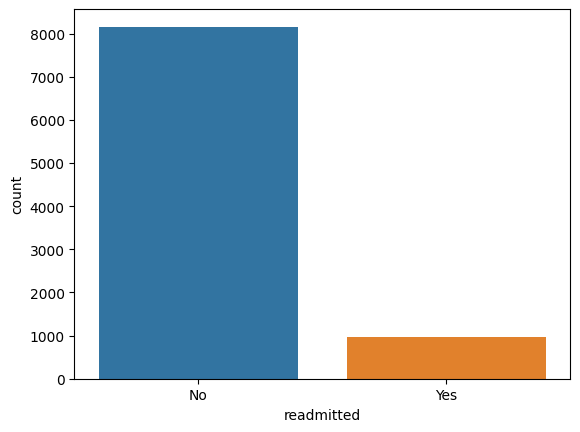

In [10]:
import seaborn as sns

sns.countplot(data=df2, x='readmitted')


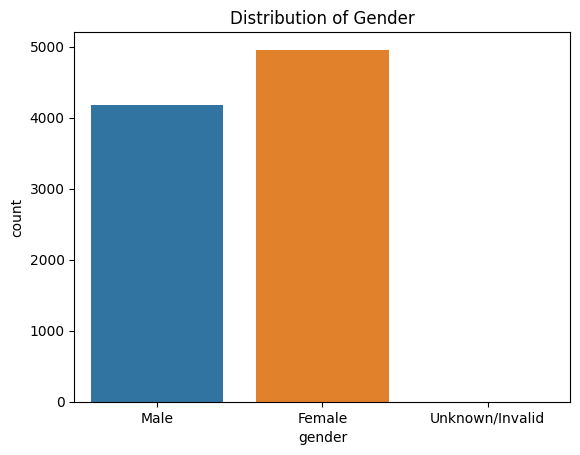

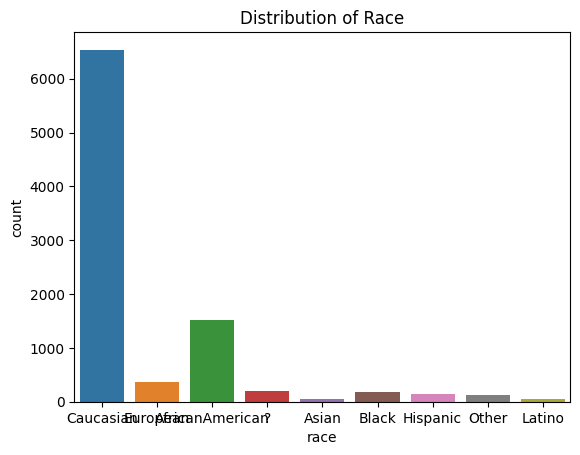

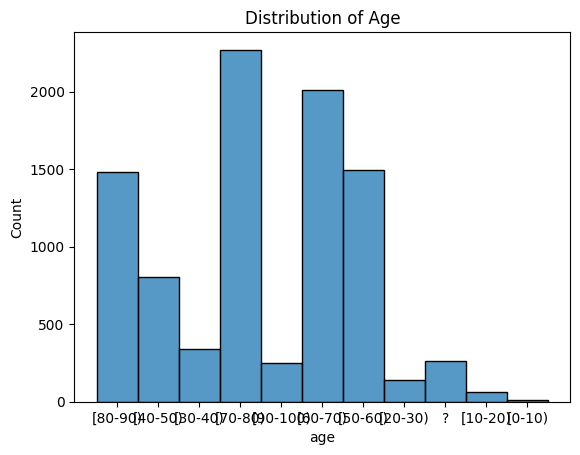

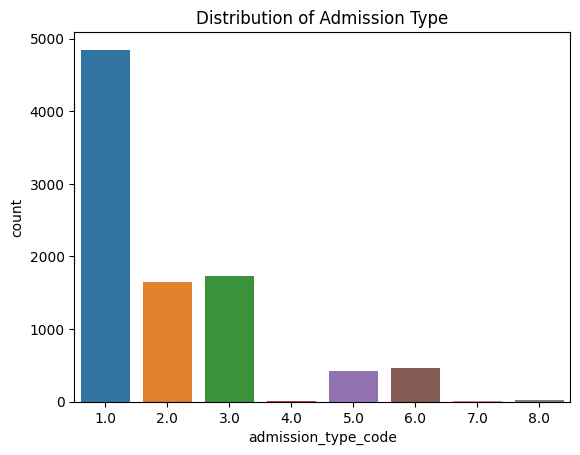

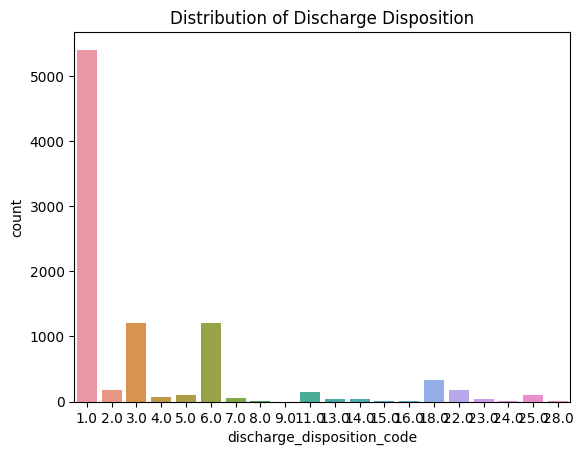

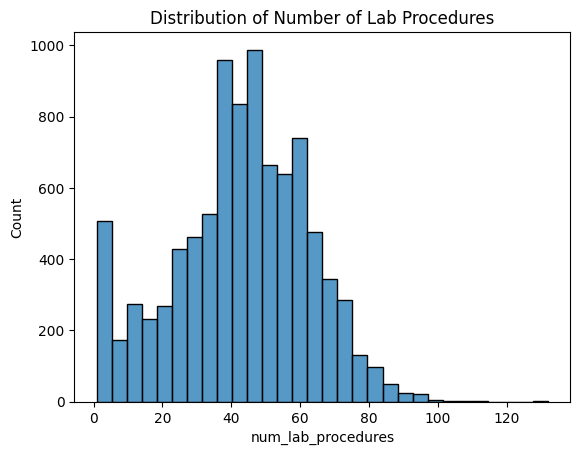

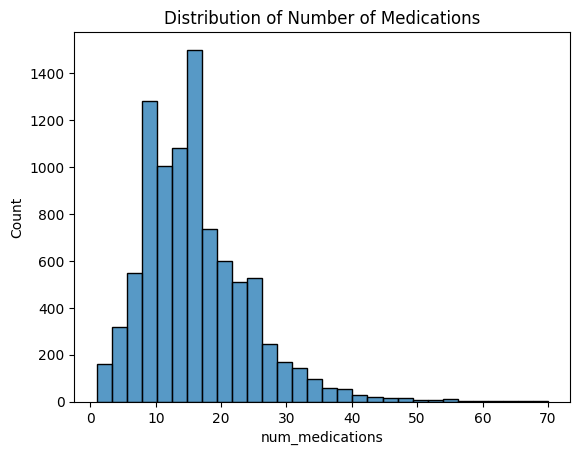

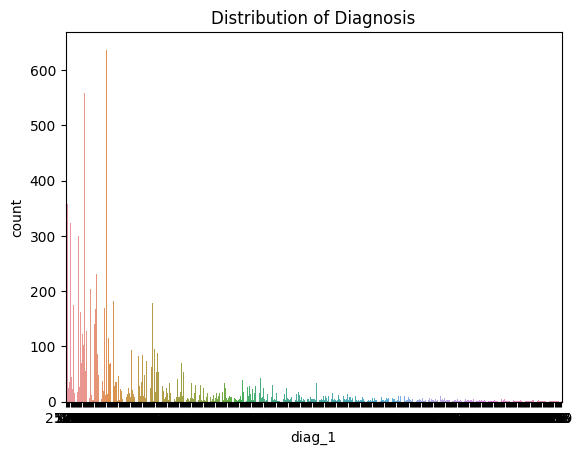

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot for gender
sns.countplot(x='gender', data=df2)
plt.title('Distribution of Gender')
plt.show()

# Plot for race
sns.countplot(x='race', data=df2)
plt.title('Distribution of Race')
plt.show()

# Plot for age
sns.histplot(x='age', data=df2, bins=10)
plt.title('Distribution of Age')
plt.show()

# Plot for admission_type_code
sns.countplot(x='admission_type_code', data=df2)
plt.title('Distribution of Admission Type')
plt.show()

# Plot for discharge_disposition_code
sns.countplot(x='discharge_disposition_code', data=df2)
plt.title('Distribution of Discharge Disposition')
plt.show()

# Plot for num_lab_procedures
sns.histplot(x='num_lab_procedures', data=df2, bins=30)
plt.title('Distribution of Number of Lab Procedures')
plt.show()

# Plot for num_medications
sns.histplot(x='num_medications', data=df2, bins=30)
plt.title('Distribution of Number of Medications')
plt.show()

# Plot for diagnosis
sns.countplot(x='diag_1', data=df2)
plt.title('Distribution of Diagnosis')
plt.show()



In [15]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Divide data into features and target
X = df2.drop('readmitted', axis=1)
y = df2['readmitted']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, ['hemoglobin_level', 'num_lab_procedures', 'num_medications', 'number_diagnoses']),
    ('cat', categorical_transformer, ['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult', 'diuretics', 'insulin', 'change', 'diabetesMed'])])

# Create pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', RandomForestClassifier(max_depth=15, min_samples_leaf=.03, class_weight="balanced", random_state=42, n_jobs=-1))])

# Fit pipeline
pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = pipeline.predict(X_test)

# Evaluate pipeline using F1 score
f1 = f1_score(y_test, y_pred, average='macro')
print("F1 score: ", f1)

# Get feature importances
feature_importances = pipeline.named_steps['classifier'].feature_importances_
features = pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names(['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult', 'diuretics', 'insulin', 'change', 'diabetesMed'])
categorical_features = list(features)
numerical_features = ['hemoglobin_level', 'num_lab_procedures', 'num_medications', 'number_diagnoses']
all_features = numerical_features + categorical_features

# Create a dictionary of feature importances
feature_importance_dict = dict(zip(all_features, feature_importances))

# Sort the dictionary by value and print it
sorted_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

print("Feature Importances:")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance:.4f}")


F1 score:  0.44266603441937763
Feature Importances:
num_lab_procedures: 0.2245
num_medications: 0.1371
hemoglobin_level: 0.0798
number_diagnoses: 0.0685
age_[50-60): 0.0597
insulin_Yes: 0.0412
medical_specialty_?: 0.0382
age_[80-90): 0.0339
insulin_No: 0.0286
payer_code_MC: 0.0272
diabetesMed_Yes: 0.0252
payer_code_?: 0.0249
A1Cresult_None: 0.0238
diabetesMed_No: 0.0206
change_No: 0.0202
age_[70-80): 0.0196
gender_Male: 0.0181
change_Yes: 0.0152
race_Caucasian: 0.0147
race_AfricanAmerican: 0.0127
gender_Female: 0.0119
age_[60-70): 0.0117
age_[40-50): 0.0081
medical_specialty_Emergency/Trauma: 0.0080
medical_specialty_InternalMedicine: 0.0064
medical_specialty_Cardiology: 0.0054
A1Cresult_Norm: 0.0054
medical_specialty_Family/GeneralPractice: 0.0045
A1Cresult_>8: 0.0042
payer_code_BC: 0.0006
race_?: 0.0000
race_Asian: 0.0000
race_Black: 0.0000
race_European: 0.0000
race_Hispanic: 0.0000
race_Latino: 0.0000
race_Other: 0.0000
gender_Unknown/Invalid: 0.0000
age_?: 0.0000
age_[0-10): 0.000